In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/details/Participants_Data_TGIH/KNN_Regressor_MachineHack.sav
/kaggle/input/details/Participants_Data_TGIH/Test.csv
/kaggle/input/details/Participants_Data_TGIH/Answer_211.xlsx
/kaggle/input/details/Participants_Data_TGIH/Anser_12.xlsx
/kaggle/input/details/Participants_Data_TGIH/Sub.xlsx
/kaggle/input/details/Participants_Data_TGIH/Answer_13.xlsx
/kaggle/input/details/Participants_Data_TGIH/Answer_22.xlsx
/kaggle/input/details/Participants_Data_TGIH/Train.csv
/kaggle/input/details/Participants_Data_TGIH/MachineHack_UnitPricePrediction.xlsx
/kaggle/input/details1/res_stack.csv


In [2]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

In [49]:
import numpy as np
import pandas as pd
Train=pd.read_csv('/kaggle/input/details/Participants_Data_TGIH/Train.csv')
Test=pd.read_csv('/kaggle/input/details/Participants_Data_TGIH/Test.csv')


In [69]:
import matplotlib.pyplot as plt


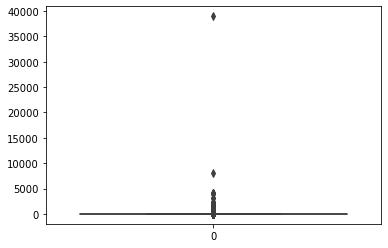

In [4]:
import seaborn as sns
sns.boxplot(data=Train.UnitPrice)

In [5]:
Train=Train.loc[Train.UnitPrice<=4200]

In [42]:
df=Train.copy()

In [7]:
def order_stats(ostats):
    if(ostats)<0:
        return 'Cancelled'
    else:
        return 'Ordered'

In [8]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [9]:
def ordered_stats(val):
    if val>999:
        return 'High_Selling'
    elif  val>250:
        return 'Moderate_Selling'
    elif  val>100:
        return 'Low_Selling'
    else:
        return 'Minimum_selling'
def country_stats(code):
    if code>=35:
        return 'Maximum'
    elif  code in [14,13,10]:
        return 'High'
    elif  code in [30,23,3,32,26,0,24]:
        return 'Moderate'
    elif  code in [18,6,12,7,31,9,1,25,19,33,17,36,29,16]:
        return 'Low'
    else:
        return 'Minimum'
        
        


In [43]:
def data_prep(df):
    df['InvoiceTime'] = pd.to_datetime(df['InvoiceDate'], format="%Y%m%d %H:%M:%S").dt.time
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%Y%m%d %H:%M:%S").dt.date
    df['Year']=pd.to_datetime(df['InvoiceDate'], format="%Y%m%d ").dt.year
    df['order_status']=df['Quantity'].apply(order_stats)
    Recency_df=df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
    Recency_df.columns=['CustomerID','LastPurshaceDate']
    import datetime as dt
    now = dt.date(2011,12,9)
    Recency_df['Recency'] = Recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)
    Recency_df.drop('LastPurshaceDate',axis=1,inplace=True)
    temp_a=df.groupby(['InvoiceNo','CustomerID'],as_index=False)['InvoiceDate'].count()
    temp_a = temp_a.rename(columns = {'InvoiceDate':'No_of_product'})
    frequency_df=temp_a.groupby(by='CustomerID',as_index=False)['No_of_product'].count()
    frequency_df.columns=['CustomerID','Frequency']
    temp_rfm = Recency_df.merge(frequency_df,on='CustomerID')
    quantiles = temp_rfm.quantile(q=[0.25,0.5,0.75])
    quantiles.to_dict()
    rfm_segmentation = temp_rfm
    rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
    rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
    rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) 
    df['Score']=rfm_segmentation['CustomerID'].map(rfm_segmentation.RFMScore)
    res_df=pd.merge(df,rfm_segmentation[['CustomerID','Recency','Frequency','RFMScore']],on='CustomerID')
    res_df=res_df.drop(['InvoiceTime','InvoiceDate','Score'],axis=1)
    stock_temp=pd.DataFrame(df.StockCode.value_counts().reset_index())
    stock_temp = stock_temp.rename(columns = {'StockCode':'sum_product'})
    stock_temp = stock_temp.rename(columns = {'index':'StockCode'})
    res_df=pd.merge(res_df,stock_temp[['StockCode','sum_product']],on='StockCode')
    country_temp=pd.DataFrame(df.Country.value_counts().reset_index())
    res_df['ordered_status']=res_df['sum_product'].apply(ordered_stats)
    res_df['country_ord_status']=df['Country'].apply(country_stats)
    res_df=res_df.drop(['InvoiceNo'],axis=1)
    res_df=res_df.drop(['sum_product'],axis=1)
    X = pd.get_dummies(res_df)
    #count_dum_temp=pd.get_dummies(X.Country)
    #X=pd.concat([X,count_dum_temp],axis=1)
    #X=X.drop(['Country'],axis=1)
    
    return X



In [44]:
tt=data_prep(df)

In [45]:
tt

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Year,Recency,Frequency,order_status_Cancelled,...,RFMScore_44,ordered_status_High_Selling,ordered_status_Low_Selling,ordered_status_Minimum_selling,ordered_status_Moderate_Selling,country_ord_status_High,country_ord_status_Low,country_ord_status_Maximum,country_ord_status_Minimum,country_ord_status_Moderate
0,1583,144,3,3.75,14056.0,35,2011,1,28,0,...,1,0,0,0,1,0,0,1,0,0
1,1583,144,1,3.75,14056.0,35,2011,1,28,0,...,1,0,0,0,1,0,0,1,0,0
2,1583,144,1,3.75,14056.0,35,2011,1,28,0,...,1,0,0,0,1,0,0,1,0,0
3,1583,144,1,3.75,14056.0,35,2011,1,28,0,...,1,0,0,0,1,0,0,1,0,0
4,1583,144,4,3.75,14056.0,35,2011,1,28,0,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284773,3398,1420,4,2.95,15279.0,35,2010,354,2,0,...,0,0,0,1,0,0,0,1,0,0
284774,3399,1419,4,2.95,15279.0,35,2010,354,2,0,...,0,0,0,1,0,0,0,1,0,0
284775,1158,3687,69,7.65,15299.0,35,2010,67,9,0,...,0,0,0,1,0,0,0,1,0,0
284776,2403,2329,-80995,2.08,16446.0,35,2011,0,3,1,...,0,0,0,1,0,0,0,1,0,0


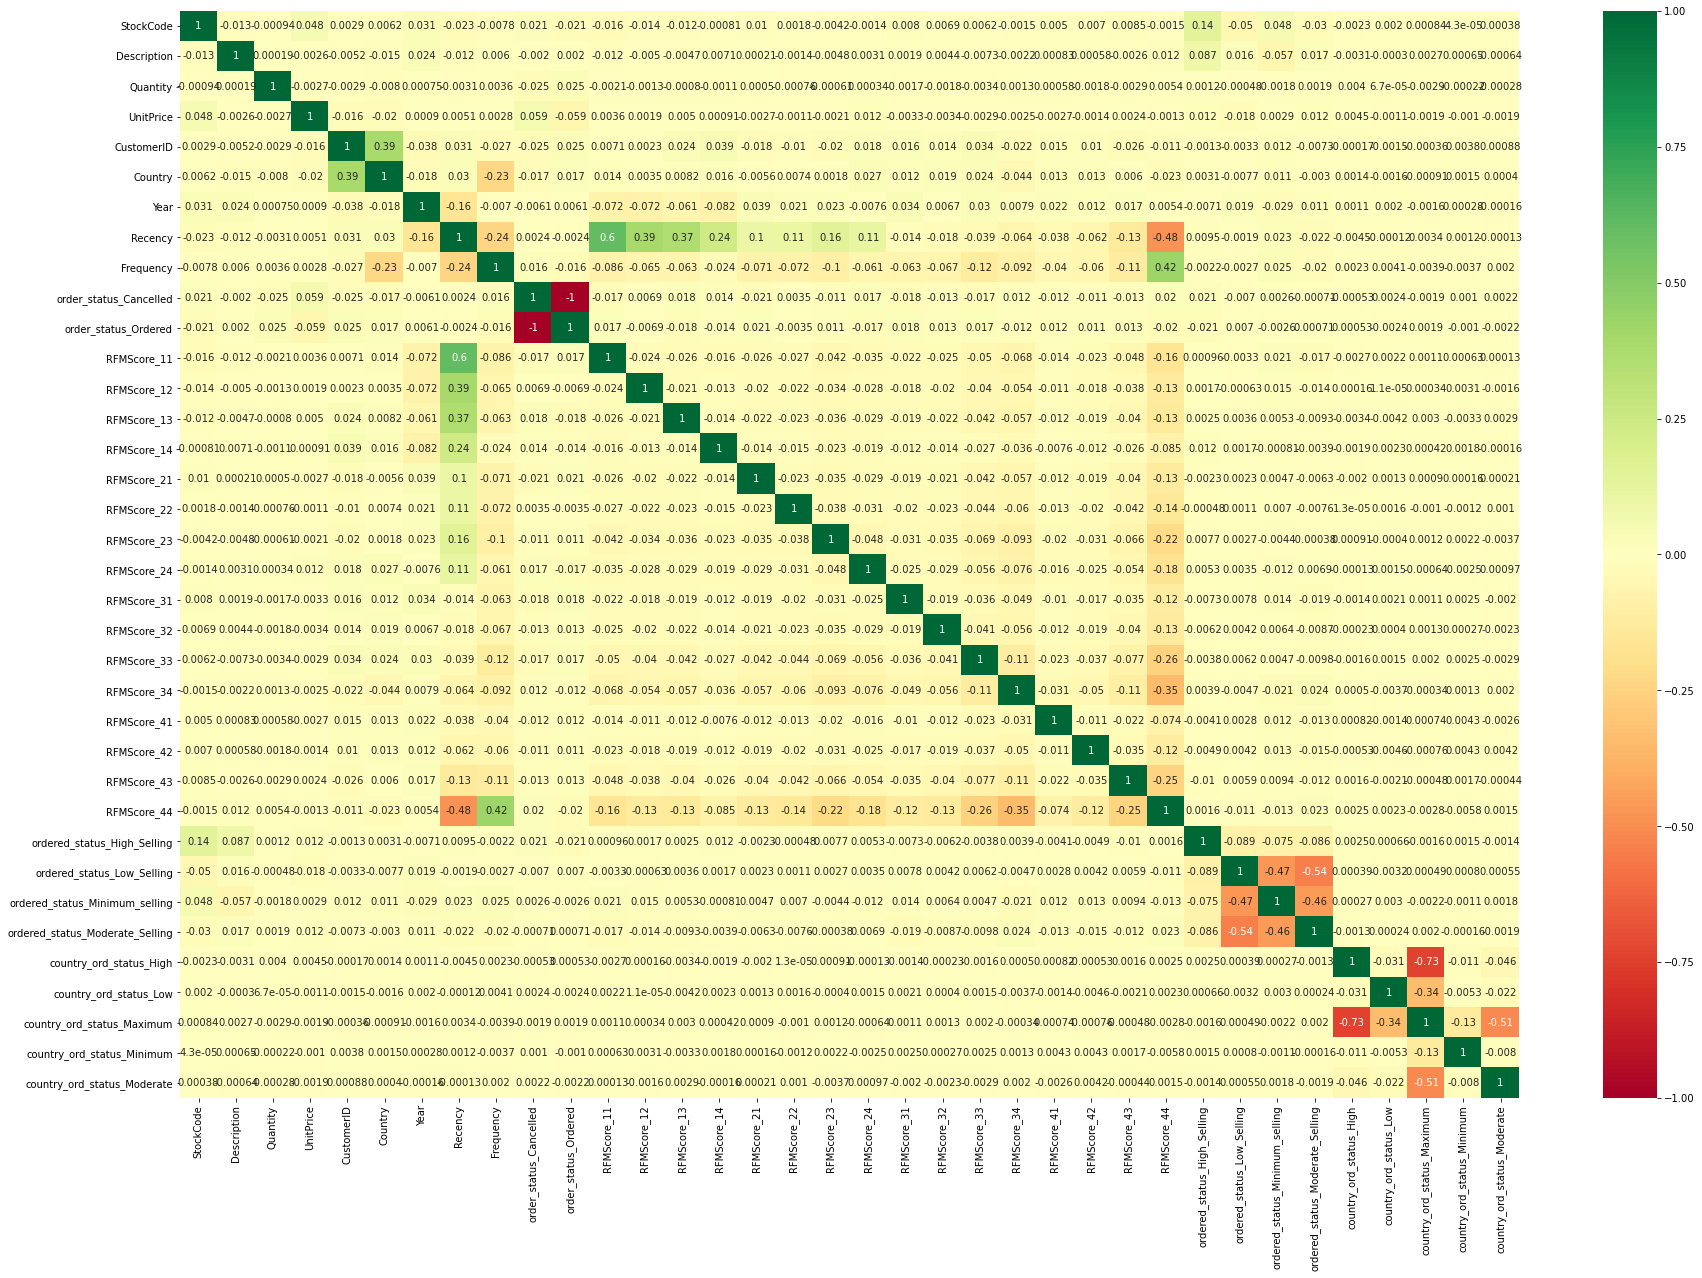

In [72]:
plt.figure(figsize=(30,20))  
p=sns.heatmap(tt.corr(), annot=True,cmap ='RdYlGn')

In [75]:
from sklearn.feature_selection import f_regression

In [76]:
from sklearn.feature_selection import SelectKBest

In [78]:
test = SelectKBest(score_func=f_regression, k=20)

In [46]:
data=tt
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.drop(['UnitPrice'], axis=1), 
                                                    data.UnitPrice, test_size=0.2, 
                                                    random_state=0)

In [50]:
Test=data_prep(Test)

In [51]:
Test

,StockCode,Description,Quantity,CustomerID,Country,Year,Recency,Frequency,order_status_Cancelled,order_status_Ordered,...,RFMScore_43,RFMScore_44,ordered_status_Low_Selling,ordered_status_Minimum_selling,ordered_status_Moderate_Selling,country_ord_status_High,country_ord_status_Low,country_ord_status_Maximum,country_ord_status_Minimum,country_ord_status_Moderate
0,1709,1079,3,16161.0,35,2011,1,22,0,1,...,0,1,0,1,0,0,0,1,0,0
1,1709,1079,2,13230.0,35,2011,4,14,0,1,...,0,1,0,1,0,0,0,1,0,0
2,1709,1079,2,15858.0,35,2011,15,5,0,1,...,1,0,0,1,0,0,0,1,0,0
3,1709,1079,2,15867.0,35,2011,5,15,0,1,...,0,1,0,1,0,0,0,1,0,0
4,1709,1079,30,12753.0,19,2011,3,10,0,1,...,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122044,2644,495,5,16965.0,35,2011,226,1,0,1,...,0,0,0,1,0,0,0,1,0,0
122045,2564,3806,4,15825.0,35,2011,172,1,0,1,...,0,0,0,1,0,0,0,1,0,0
122046,2429,360,24,15825.0,35,2011,172,1,0,1,...,0,0,0,1,0,0,0,1,0,0
122047,1622,660,-8,15221.0,35,2010,366,2,1,0,...,0,0,0,1,0,0,0,1,0,0


In [52]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
x_train_robust = scaler.fit_transform(x_train[['StockCode','Description','Quantity','CustomerID','Year','Recency','Frequency']])
# transform "x_test"
x_test_robust = scaler.transform(x_test[['StockCode','Description','Quantity','CustomerID','Year','Recency','Frequency']])
Test_robust=scaler.transform(Test[['StockCode','Description','Quantity','CustomerID','Year','Recency','Frequency']])

In [53]:
x_train_robust

array([[ 0.23907455, -0.19179601,  0.1       , ...,  0.        ,
        -0.31578947,  0.28571429],
       [ 0.43187661, -0.79268293, -0.4       , ...,  0.        ,
        -0.21052632, -0.42857143],
       [ 1.50299914, -0.13636364, -0.6       , ...,  0.        ,
         0.18421053, -0.07142857],
       ...,
       [ 0.67352185, -0.66186253,  4.3       , ...,  0.        ,
        -0.36842105,  0.21428571],
       [ 1.46958012, -0.12638581,  0.5       , ...,  0.        ,
        -0.15789474,  3.07142857],
       [ 0.53898886,  0.54822616,  0.3       , ...,  0.        ,
        -0.28947368,  0.07142857]])

In [54]:
y_train_temp=np.log1p(y_train)
y_test_temp=np.log1p(y_test)


In [55]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='yeo-johnson', standardize=True)
y_pwr_train = y_train.values.reshape(-1,1)
# power transform the raw data

y_pwr_train = power.fit_transform(y_pwr_train)

y_pwr_test=y_test.values.reshape(-1,1)
y_pwr_test = power.fit_transform(y_pwr_test)


In [56]:
from sklearn.preprocessing import MinMaxScaler
scal=MinMaxScaler()

# **Need Repair**

In [ ]:
[['StockCode','Description','Quantity','CustomerID','Year','Recency','Frequency']]

In [59]:
x_train_robust

array([[ 0.23907455, -0.19179601,  0.1       , ...,  0.        ,
        -0.31578947,  0.28571429],
       [ 0.43187661, -0.79268293, -0.4       , ...,  0.        ,
        -0.21052632, -0.42857143],
       [ 1.50299914, -0.13636364, -0.6       , ...,  0.        ,
         0.18421053, -0.07142857],
       ...,
       [ 0.67352185, -0.66186253,  4.3       , ...,  0.        ,
        -0.36842105,  0.21428571],
       [ 1.46958012, -0.12638581,  0.5       , ...,  0.        ,
        -0.15789474,  3.07142857],
       [ 0.53898886,  0.54822616,  0.3       , ...,  0.        ,
        -0.28947368,  0.07142857]])

In [30]:
kf = KFold(n_splits=5, random_state=10, shuffle=True)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

def cv_rmse(model, X=x_train_robust):
    rmse = np.sqrt(-cross_val_score(model, x_train_robust, y_train_temp, scoring="neg_mean_squared_error", cv=kf))
    return rmse

In [60]:
lightgbm =  LGBMRegressor(objective='regression', 
                       num_leaves=14,
                       learning_rate=0.05, 
                       n_estimators=13500,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=5, 
                       bagging_seed=10,
                       feature_fraction=0.2,
                       feature_fraction_seed=10,
                       min_sum_hessian_in_leaf = 14,
                       verbose=-1,
                       random_state=42,
                          nfold=5
                         )

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.05, 
                             n_estimators=4900,
                             max_depth=5, 
                             min_child_weight=1.7817,
                             gamma=0.0468,  
                             subsample=0.5213, 
                             colsample_bytree=0.4603,

                             nthread = -1,

                             
                             reg_lambda=0.8571,
                             

                             reg_alpha=0.4640, 
                             random_state =17,
                      nfold=5)




# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=1000,
                                learning_rate=0.05,
                                max_depth=9,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=21) 

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1000,
                          max_depth=18,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)


catBoot = CatBoostRegressor(iterations=10000,
                          learning_rate=0.01,
                          depth=10,max_bin=250, 
                       
                      random_state=42,
                            task_type="GPU",
                           devices='0:1')

knn =  KNeighborsRegressor(n_neighbors = 4,  weights = 'distance', p=1)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm,catBoot,knn,gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [33]:
scores = {}

In [61]:
def train_test(model_name,result=False):
    model_full_data = model_name.fit(x_train_robust, y_train_temp)
    print("Accuracy on Traing set: ",model_full_data.score(x_train_robust,y_train_temp))
    print("Accuracy on Testing set: ",model_full_data.score(x_test_robust,y_test_temp))
    if(result==True):
        test_pred_ridge=model_full_data.predict(Test_robust)
        ridge_pred = np.expm1(test_pred_ridge)
        result = pd.DataFrame(data=ridge_pred).round(2)
        return result
        #result.to_excel("Answer.xlsx",index=False)


In [ ]:
..

# **LGBMRegressor**

In [ ]:
stack_gen_model = stack_gen.fit(np.array(x_train_robust), np.array(y_train_temp))
        
    

In [ ]:
print("Accuracy on Traing set: ",stack_gen_model.score(x_train_robust,y_train_temp))
print("Accuracy on Testing set: ",stack_gen_model.score(x_test_robust,y_test_temp))

In [ ]:
test_pred_ridge=stack_gen_model.predict(Test_robust)
ridge_pred = np.expm1(test_pred_ridge)
result = pd.DataFrame(data=ridge_pred).round(2)


In [ ]:
res_stack=result
res_stack.to_csv('res_stack.csv',index=False)

In [62]:
res_bgm=train_test(lightgbm,True)

Accuracy on Traing set:  0.8335477491894323
Accuracy on Testing set:  0.8075076612425469


Accuracy on Traing set:  0.8669344863759714

Accuracy on Testing set: 0.8412355944737395

12:37 minutes



In [63]:
res_bgm
res_bgm.to_csv('res_bgm.csv',index=False)

In [64]:
res_xg=train_test(xgboost,True)

[14:00:19] WARNING: ../src/learner.cc:516: 
Parameters: { nfold } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy on Traing set:  0.9616264288692259
Accuracy on Testing set:  0.9475879192824243


Accuracy on Traing set:  0.9592045104058529

Accuracy on Testing set:  0.9447047519089277

15

In [65]:
res_xg
#res_xg.to_csv('res_xg.csv',index=False)

,0
0,1.95
1,1.76
2,1.78
3,1.85
4,1.92
...,...
122044,1.25
122045,3.50
122046,0.87
122047,6.85


In [66]:
res_gbr=train_test(gbr,True)

Accuracy on Traing set:  0.919271373687154
Accuracy on Testing set:  0.8961841023678749


Accuracy on Traing set:  0.9517776150681873

Accuracy on Testing set:  0.9375358486071952

30 minutes

In [67]:
res_gbr
#res_gbr.to_csv('res_gbr.csv',index=False)

,0
0,1.99
1,1.79
2,2.03
3,1.88
4,1.86
...,...
122044,1.55
122045,3.03
122046,0.63
122047,8.24


In [ ]:
res_rf=train_test(rf,True)

Accuracy on Traing set:  0.8403255519128934
    
Accuracy on Testing set:  0.8209166078141287

14

In [ ]:
res_rf
#res_rf.to_csv('res_rf.csv',index=False)

In [ ]:
res_cat=train_test(catBoot,True)

Accuracy on Traing set:  0.8258666521215552

Accuracy on Testing set:  0.7954740764068092

In [35]:
res_knn=train_test(knn,True)

Accuracy on Traing set:  0.9973748288104816
Accuracy on Testing set:  0.6051833520733245


In [36]:
res_knn

,0
0,1.58
1,1.65
2,2.13
3,1.65
4,3.07
...,...
122044,0.71
122045,4.95
122046,1.36
122047,8.95


In [ ]:
res_knn

In [ ]:
ensemble = res_knn*0.15 + res_rf*0.2 + res_gbr*0.2 + res_xg*0.35 + res_bgm*0.1

In [ ]:
ensemble2 = res_knn*0.1 + res_rf*0.1 + res_gbr*0.1 + res_xg*0.2 + res_bgm*0.05+res_cat*0.05+res_stack*0.3

In [ ]:
ensemble2

In [ ]:
ensemble

In [ ]:
sub = pd.DataFrame()

ans = ensemble2.round(2)
ans.to_csv('submission.csv',index=False)

In [ ]:
ans

In [ ]:
result.to_excel("Answer_30.xlsx",index=False)